In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
sns.set_style("darkgrid")

In [ ]:
#Valores úteis
DicioRacacor = {"01":"BRANCA", 
                "02": "PRETA", 
                "03": "PARDA", 
                "04": "AMARELA", 
                "05": "INDÍGENA", 
                "99": "S/ INFO",
                "00": "00"}

#Tratamento coluna Raça/Cor
def TrataRacaCor(x):
  try:
    return DicioRacacor[x]
  except:
    pass
                

In [ ]:
#Montagem do Drive Google (Conta covid.data.mais@gmail.com)
from google.colab import drive 
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#!pip install pyarrow

In [ ]:
#Definindo colunas úteis e dicionário com dtypes do dataset SIA


colunasres = ["PA_CODUNI","PA_UFMUN", "PA_CMP", "PA_IDADE", "PA_SEXO", "PA_RACACOR", "PA_CIDPRI", 
               "PA_CIDSEC", "PA_CIDCAS", "PA_PROC_ID","PA_DOCORIG","PA_VALPRO", "NU_PA_TOT"]

dtype = np.dtype

dict_typesres = {'PA_CODUNI': dtype('int32'),'PA_UFMUN': dtype('O'), 'PA_CMP': dtype('datetime64[ns]'), 'PA_CIDPRI': dtype('O'), 
                 'PA_CIDSEC': dtype('O'),'PA_CIDCAS': dtype('O'), 'PA_IDADE': dtype('int32'), 
               'PA_SEXO': dtype('O'), 'PA_RACACOR': dtype('O'), 'PA_PROC_ID': dtype('O'), 'PA_DOCORIG':dtype('O'),
               'PA_VALPRO': dtype('float64'),'NU_PA_TOT': dtype('float64')}                     

In [ ]:
#Defininddo DataFrame municípios e coordenadas
path_MUNI = '/content/gdrive/MyDrive/DERMATITE_ATOPICA/municipios.csv'
dfMUNI = pd.read_csv(path_MUNI, usecols=["codigo_ibge", "nome", "latitude", "longitude" ], dtype={"codigo_ibge":"object"} )# columns=["CO_MUNICIP", "DS_NOME", "DS_NOMEPAD"]).set_index("CO_MUNICIP")
dfMUNI["codigo_ibge"] = dfMUNI["codigo_ibge"].apply(lambda x: x[:-1])
dfMUNI = dfMUNI.set_index("codigo_ibge")
#dfIBGE.head()

#Defininddo DataFrame CID e descrição da doença
path_SIGTAP_CID = '/content/gdrive/MyDrive/DERMATITE_ATOPICA/tb_sigtap_cid/tb_sigtap_cid.parquet'
dfCID = pd.read_parquet(path_SIGTAP_CID, engine='pyarrow', columns=["CO_CID", "NO_CID"]).set_index("CO_CID")
#dfCID.head()

#Defininddo DataFrame Código do procedimento
path_SIGTAP_PROC = '/content/gdrive/MyDrive/DERMATITE_ATOPICA/tb_sigtap_procedimento/tb_sigtap_procedimento_1.parquet'
dfPROC = pd.read_parquet(path_SIGTAP_PROC, engine='pyarrow', columns=["CO_PROCEDIMENTO", "NO_PROCEDIMENTO"]).set_index("CO_PROCEDIMENTO")
#dfPROC.head()
dfMUNI.head()

,nome,latitude,longitude
codigo_ibge,,,
520005,Abadia de Goiás,-16.75730,-49.4412
310010,Abadia dos Dourados,-18.48310,-47.3916
520010,Abadiânia,-16.19700,-48.7057
310020,Abaeté,-19.15510,-45.4444
150010,Abaetetuba,-1.72183,-48.8788


In [ ]:
#Célula para criar o csv geral Ambulatorial. Executar apenas se necessário refazer


start = time.time()

tempdf = pd.DataFrame(columns= colunasres)
df = pd.DataFrame(columns= colunasres)
ageseries = pd.Series(range(0,1000), dtype="int")
dferrors = pd.DataFrame(columns= colunasres)

  #Dicionário cache do total geral de atendimentos SIA
cache = {}
cache["Registros"] = np.array([0])
cache["0-F-M"] = np.array([0,0,0])
cache["00-AM-BR-IN-PAR-PRE-SINF"] = np.array([0,0,0,0,0,0,0])

path_sia = '/content/gdrive/MyDrive/DERMATITE_ATOPICA/restante_arquivos_SIA'
filelist = [i for i in os.listdir(path_sia)]

print("Imprimindo registros a cada 500 arquivos")
for i in filelist:

  if int(i[5:10])%(500) == 0:
    print(f"Arquivo lido: {i}") 

  tempdf = pd.read_parquet(path_sia+"/"+i, engine='pyarrow', columns= colunasres)
  tempdf["PA_CMP"] = tempdf["PA_CMP"].apply(lambda x: x[:4]+"-"+x[4:6]+"-"+"01")
  tempdf["PA_CMP"] = tempdf["PA_CMP"].astype("datetime64[ns]")
  tempdf["PA_RACACOR"] = tempdf["PA_RACACOR"].apply(TrataRacaCor)
  maskl = (tempdf["PA_CIDPRI"].str.contains("L") | tempdf["PA_CIDSEC"].str.contains("L") | tempdf["PA_CIDCAS"].str.contains("L"))
  
  try:
    ageseries += tempdf.groupby("PA_IDADE").count()["PA_UFMUN"]
  except: 
    print(f"PA_IDADE: Máximo: {tempdf['PA_IDADE'].max()}, Mínimo: {tempdf['PA_IDADE'].min()}")
    pass    

  try:

    cache["Registros"] += np.array(len(tempdf))
    cache["0-F-M"] += tempdf.groupby("PA_SEXO").count()["PA_CMP"].values
    cache["00-AM-BR-IN-PAR-PRE-SINF"] += tempdf[["PA_CMP","PA_RACACOR"]].groupby("PA_RACACOR").count()["PA_CMP"].values  
  except: 
     dferrors = dferrors.append(tempdf.astype(dict_typesres))
    pass

  tempdf = tempdf[maskl]
  df = df.append(tempdf.astype(dict_typesres))







end = time.time()
print(f"Criação do dataset executada em {(end-start)/60} minutos")  
print(f"Número de arquivos lidos: {len(filelist)}")
print(f"Número de registros com CID L: {len(df)}")
print(f"Número de registros lidos: {cache}")
df.info()
df.to_csv("/content/gdrive/MyDrive/DERMATITE_ATOPICA"+"/"+"df_SIA_total_L_2.csv")
#ageseries.to_csv("/content/gdrive/MyDrive/DERMATITE_ATOPICA"+"/"+"df_IDADES_SIA_total_2.csv")


Imprimindo registros a cada 500 arquivos
Arquivo lido: part-04500-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-05000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-03500-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-04000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-02500-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-03000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-01500-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-02000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-00500-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-01000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Arquivo lido: part-00000-3c6f499e-a06e-4ae5-99a2-041c0cba3b71-c000.snappy.parquet
Criação do dataset executada em 321.45038652420044 minuto

In [ ]:
#Dicionário 'cache' com registro do número de linhas processadas e distribuição por Sexo e Raça/Cor 
cache

{'0-F-M': array([458511106, 752591604, 514895663]),
 '00-AM-BR-IN-PAR-PRE-SINF': array([458511106, 101895079, 441336758,   1007853, 295655486,  74664340,
        352927751]),
 'Registros': array([1742743969])}

Foram lidos 5.251 arquivos parquet, resultando em 1.742.743.969 linhas!

In [ ]:
#Verificação do dataset formado
df = pd.read_csv("/content/gdrive/MyDrive/DERMATITE_ATOPICA"+"/"+"df_SIA_total_L.csv")
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,PA_UFMUN,PA_CMP,PA_IDADE,PA_SEXO,PA_RACACOR,PA_CIDPRI,PA_CIDSEC,PA_CIDCAS,PA_QTDPRO,PA_PROC_ID,PA_DOCORIG,PA_VALPRO,NU_PA_TOT,PA_AUTORIZ
0,2396,260120,2017-04-01,67,M,S/ INFO,L029,0000,0000,1,401010104,I,11.84,11.84,0000000000000
1,2412,260120,2017-04-01,51,M,S/ INFO,L029,0000,0000,1,401010104,I,11.84,11.84,0000000000000
2,5571,261160,2017-04-01,25,F,PARDA,L700,0000,0000,0,604590024,P,0.00,0.00,2617200229710
3,5572,261160,2017-04-01,37,F,PARDA,L700,0000,0000,60,604590024,P,0.00,0.00,2617200229545
4,5573,261160,2017-04-01,14,M,BRANCA,L700,0000,0000,0,604590024,P,0.00,0.00,2617200228973


In [ ]:
#Prévia dos resultados com CID L20
maskl20 = (df["PA_CIDPRI"].str.contains("L20")) | (df["PA_CIDSEC"].str.contains("L20")) | (df["PA_CIDCAS"].str.contains("L20"))
dfl20 = df[maskl20]

In [ ]:
dfl20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46198 entries, 231 to 5324315
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  46198 non-null  int64  
 1   PA_UFMUN    46198 non-null  int64  
 2   PA_CMP      46198 non-null  object 
 3   PA_IDADE    46198 non-null  int64  
 4   PA_SEXO     46198 non-null  object 
 5   PA_RACACOR  46198 non-null  object 
 6   PA_CIDPRI   46198 non-null  object 
 7   PA_CIDSEC   46198 non-null  object 
 8   PA_CIDCAS   46198 non-null  object 
 9   PA_QTDPRO   46198 non-null  int64  
 10  PA_PROC_ID  46198 non-null  int64  
 11  PA_DOCORIG  46198 non-null  object 
 12  PA_VALPRO   46198 non-null  float64
 13  NU_PA_TOT   46198 non-null  float64
 14  PA_AUTORIZ  46198 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 5.6+ MB


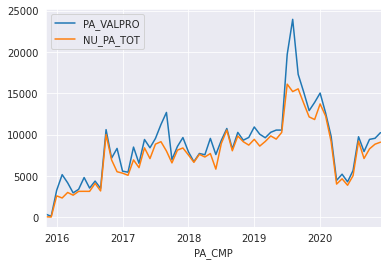

In [ ]:
dfl20.groupby("PA_CMP").sum().plot()

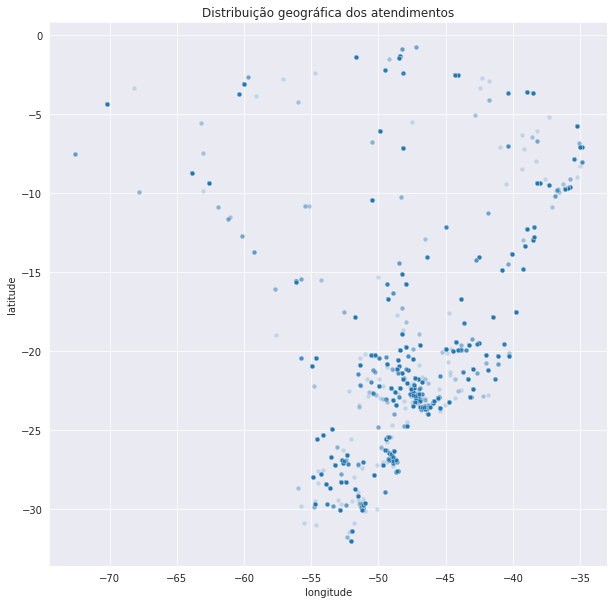

In [ ]:
#Distribuição geográfica dos atendimentos
plt.figure(figsize=(10,10))
plt.title("Distribuição geográfica dos atendimentos")
sns.scatterplot(y=dfl20coord["latitude"], x=dfl20coord["longitude"], s=20, alpha=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


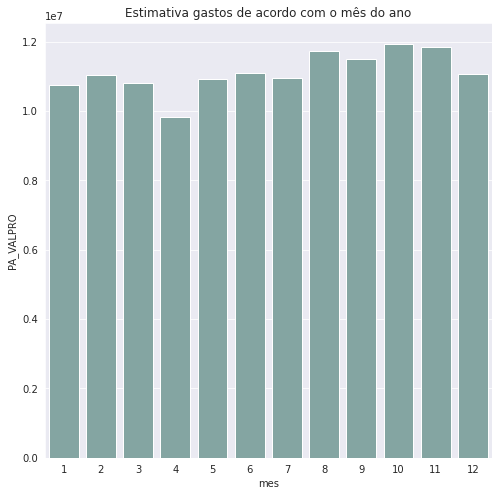

In [ ]:
#Estimativa gastos de acordo com o mês do ano
df["mes"] = df["PA_CMP"].dt.month
plt.figure(figsize=(8,8));
plt.title("Estimativa gastos de acordo com o mês do ano");
sns.barplot(df.groupby("mes").sum()["PA_VALPRO"].index, df.groupby("mes").sum()["PA_VALPRO"], color="#7eaba6");
